# Cyberbullying On Social Media

# Feature Engineering

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

import multiprocessing

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding='utf-8-sig', engine='python')

In [3]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = 0.1
VALIDATION_SPLIT_SIZE = 0.2

In [4]:
comments = df['tidy_text'].values
labels = df['label_bullying'].values

***

**Pretrained Word Embeddings**

***

A word embedding is a class of approaches for representing words and documents using a dense vector representation.
It is considered an improvement over more the traditional encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values.

Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.

The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

The position of a word in the learned vector space is referred to as its embedding. Two popular examples of methods of learning word embeddings from text include: Word2Vec, GloVe or FastText.

**GloVe**

Global Vectors for Word Representation (GloVe) is an unsupervised learning algorithm for obtaining vector representations for words. It’s basically computing co-word occurrences statistics from a large corpus. This is different compared to Word2Vec skip-gram or CBOW models, which is trained using model predictions of the current word given a window of surrounding words.
Ultimately though, GloVe is concerned with achieving word embeddings. The goal is to find a high dimensional vector representation for each word. This is different from BOW models which can result in a very sparse matrix with no attractive mathematical properties other than classification in machine learning. For word embeddings, we can create structures and reason on word distances on this high dimensional space. We’ll find for example, the word “cat” is close to other feline entities such as “tiger”, “kitty” and “lion”. We’ll also see that “cat” is farther than “dog” as compared to “kitty”. 

**FastText**

FastText was developed by Facebook with a stable release being open-sourced in 2017. The most noticeable difference between fastText and word2vec is that fastText splits out words using n-gram characters. This approach is a significant improvement over word2vec for two reasons:
1. The ability to infer out-of-vocabulary words.
2. The robustness to spelling mistakes and typos. The same character level modelling also means that fastText is robust enough to handle spelling variations. This is particularly useful in the analysis of Social Media content.

***

**GloVe and FastText**


In [5]:
GLOVE_FILENAME = 'glove.twitter.27B.200d.txt'

In [6]:
FASTTEXT_FILENAME = 'crawl-300d-2M.vec'

In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
wpt = nltk.WordPunctTokenizer()
tokenized_comments = [wpt.tokenize(comment) for comment in comments]

First load the embeddings separately and combine them later.

In [9]:
glove2word2vec(glove_input_file = GLOVE_FILENAME, word2vec_output_file = "gensim_glove_vectors.txt")

(1193514, 200)

In [10]:
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary = False)

In [11]:
ft_model = KeyedVectors.load_word2vec_format(FASTTEXT_FILENAME, binary = False)

Let's check the most similar words and compare to the previously trained Word2Vec.

In [13]:
ft_model.wv.most_similar("hate")

[('despise', 0.7917031645774841),
 ('HATE', 0.7900916934013367),
 ('Hate', 0.7767899632453918),
 ('detest', 0.7619196176528931),
 ('loathe', 0.7572115659713745),
 ('dislike', 0.7513971924781799),
 ('hating', 0.704501748085022),
 ('hatred', 0.6993839740753174),
 ('hated', 0.697160005569458),
 ('dispise', 0.657025158405304)]

In [14]:
glove_model.wv.most_similar("hate")

[('shit', 0.8846099376678467),
 ('hell', 0.840812623500824),
 ('bitch', 0.8312326669692993),
 ('fucking', 0.830012321472168),
 ('damn', 0.8262269496917725),
 ('wtf', 0.8196028470993042),
 ('fuckin', 0.791408360004425),
 ("n't", 0.7901071310043335),
 ('that', 0.7883279323577881),
 ('nigga', 0.7844579219818115)]

FastText finds a lot of similarities here mostly based on common lexical root (HATE, Hate, hating, hated, hatred) rather than synonyms or correlations like Glove.

In [14]:
ft_model.wv.most_similar("asshole")

[('a-hole', 0.7980272769927979),
 ('assholes', 0.7966619729995728),
 ('dickhead', 0.7765179872512817),
 ('asshat', 0.763733983039856),
 ('douchebag', 0.7635151743888855),
 ('shithead', 0.7561006546020508),
 ('ass-hole', 0.7475216388702393),
 ('fucker', 0.7441247701644897),
 ('fucktard', 0.7440173029899597),
 ('fuckhead', 0.7433903813362122)]

In [15]:
glove_model.wv.most_similar("asshole")

[('faggot', 0.759504497051239),
 ('fucker', 0.7343281507492065),
 ('cunt', 0.7339721918106079),
 ('dumbass', 0.7336857318878174),
 ('assholes', 0.7178757786750793),
 ('dick', 0.7010302543640137),
 ('twat', 0.6922847032546997),
 ('bastard', 0.6884878873825073),
 ('douchebag', 0.6879569888114929),
 ('whore', 0.6878525614738464)]

Again Glove seems to find richer semantic similarities.

In [16]:
ft_model.wv.most_similar("great")

[('fantastic', 0.7921966910362244),
 ('terrific', 0.7699298858642578),
 ('good', 0.7414898872375488),
 ('wonderful', 0.7349137663841248),
 ('geat', 0.7158622741699219),
 ('GREAT', 0.7043700218200684),
 ('excellent', 0.6949211955070496),
 ('tremendous', 0.6918985247612),
 ('grest', 0.6787239909172058),
 ('awesome', 0.6748533248901367)]

In [17]:
glove_model.wv.most_similar("great")

[('good', 0.8672515749931335),
 ('amazing', 0.858441948890686),
 ('awesome', 0.839326024055481),
 ('wonderful', 0.832552433013916),
 ('fantastic', 0.8157325387001038),
 ('well', 0.7814643979072571),
 ('have', 0.7786161303520203),
 ('such', 0.7777701616287231),
 ('hope', 0.7770050168037415),
 ('there', 0.7764202356338501)]

At a first glance, Glove seems to have a much richer vocabulary and finds more meaningful similarities, based on synonyms rather than variations of the same word, as seems to be the case for FastText. Note that this is not a general statement, but rather applies to the limited number of words I've chosen here as an example.

In the next part I'm going to create a word2vec model and train it my corpus. Then using build_vocab I will update the embeddings with the ones from the pre-trained Glove and FastText and retrain on my corpus.

In [26]:
FEATURE_SIZE = 100

In [27]:
cores = multiprocessing.cpu_count() # Count the number of cores in the computer

w2v_model = gensim.models.Word2Vec(tokenized_comments, 
                                   size = FEATURE_SIZE, # Dimensionality of the feature vectors. Typical values (50, 300), depending on vocabulary size. 
                                   window = 5, # The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target.
                                   # Typical values are (2, 10).
                                   min_count = 100, #Ignores all words with total absolute frequency lower than this - (2, 100).
                                   workers = cores, 
                                   iter = 10 # Number of iterations (epochs) over the corpus. 5 is a good starting point. 
                                  )

In [28]:
# building the vocabulary again will reset the count.
count = w2v_model.corpus_count

Use first FastText and then Glove since word embeddings will be updated. As we've seen before Glove has much better embeddings and finds much more meaningful similarities. 

In [29]:
w2v_model.build_vocab([list(ft_model.vocab.keys())], update = True)
# w2v_model.intersect_word2vec_format(FASTTEXT_FILENAME, binary=True)
w2v_model.train(tokenized_comments, total_examples = count, epochs = w2v_model.iter)

(5468195, 9024580)

In [30]:
w2v_model.build_vocab([list(glove_model.vocab.keys())], update=True)
# w2v_model.intersect_word2vec_format(GLOVE_FILENAME, binary=True)
w2v_model.train(tokenized_comments, total_examples = count, epochs = w2v_model.iter)

(5468492, 9024580)

In [31]:
# Build word vector for training 
# Code from: https://medium.com/district-data-labs/modern-methods-for-sentiment-analysis-694eaf725244
def word_vector(text):
    vec = np.zeros(FEATURE_SIZE).reshape((1, FEATURE_SIZE))
    count = 0.
    for word in text:
        try:
            vec += w2v_model[word].reshape((1, FEATURE_SIZE))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

gloveft_arrays = np.concatenate([word_vector(z) for z in tokenized_comments])

In [32]:
gloveft_arrays.shape

(11033, 100)

In [33]:
np.save("gloveft_features.npy", np.array(gloveft_arrays))

In [34]:
w2v_model.save("gloveft.model")

Borrowing the code from https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d, let's visualize the embeddings found by combining the two models.

In [35]:
keys = ['fuck', 'asshole', 'shit', 'hate', 'bitch', 'damn', 'suck']

In [36]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [37]:
from  sklearn.manifold import TSNE

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne = TSNE(perplexity=100, n_components=2, init='pca', n_iter=1000, random_state=RANDOM_STATE)
embeddings_tsne = np.array(tsne.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

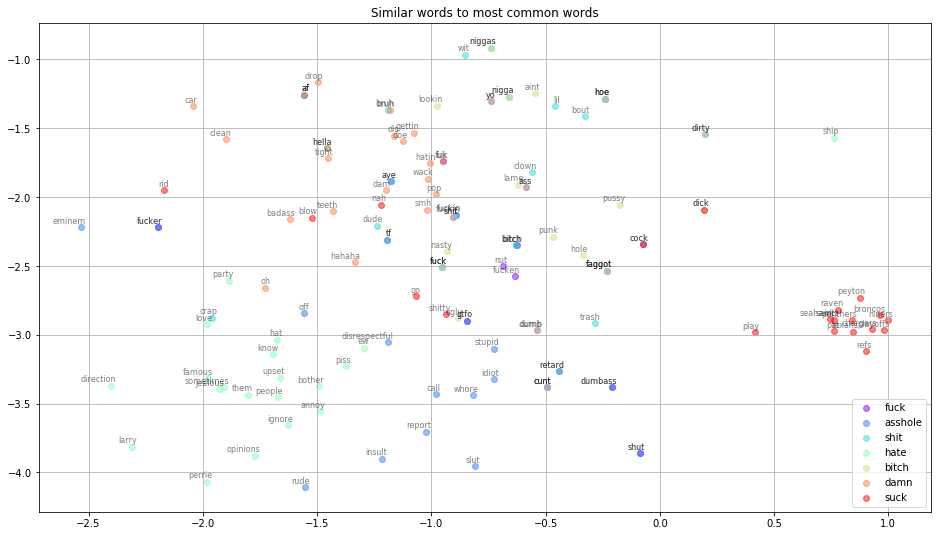

In [38]:
import matplotlib.cm as cm
plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for label, embeddings, words, color in zip(keys, embeddings_tsne, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=np.array([color]), alpha=0.5, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
plt.legend(loc=4)
plt.title('Similar words to most common words')
plt.grid(True)
plt.show()

In [39]:
w2v_model.wv.most_similar("hate")

[('ignore', 0.4308149814605713),
 ('upset', 0.39012598991394043),
 ('hat', 0.372810423374176),
 ('perrie', 0.34126049280166626),
 ('sometimes', 0.32696348428726196),
 ('jealous', 0.3183085322380066),
 ('annoy', 0.3030823767185211),
 ('ship', 0.2914774417877197),
 ('bother', 0.2905590534210205),
 ('love', 0.28317204117774963)]

In [40]:
w2v_model.wv.most_similar("asshole")

[('bitch', 0.4400940537452698),
 ('insult', 0.4317570924758911),
 ('call', 0.41583579778671265),
 ('cunt', 0.4046573042869568),
 ('fuck', 0.394946813583374),
 ('idiot', 0.3792377710342407),
 ('gtfo', 0.36895516514778137),
 ('report', 0.3640785217285156),
 ('dumbass', 0.36379364132881165),
 ('fucker', 0.3590446710586548)]

In [41]:
w2v_model.wv.most_similar("great")

[('good', 0.5842822790145874),
 ('awesome', 0.5627833008766174),
 ('amaze', 0.5249366164207458),
 ('talented', 0.4459196627140045),
 ('nice', 0.3718303442001343),
 ('talent', 0.3514777421951294),
 ('sir', 0.3440554440021515),
 ('inspire', 0.33812206983566284),
 ('bless', 0.30848726630210876),
 ('sweet', 0.3055313527584076)]

For the most part, the similar word are the same as when using word2vec only, but not always. An interesting combination is the hate-love similarity found here. The order/similarity is different and my hope is that this will make a difference in the predictive modelling part.